In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

In [72]:
dataset = pd.read_csv('AAPL.csv')
df = pd.DataFrame(dataset)
df['Date'] = pd.to_datetime(df['Date'])

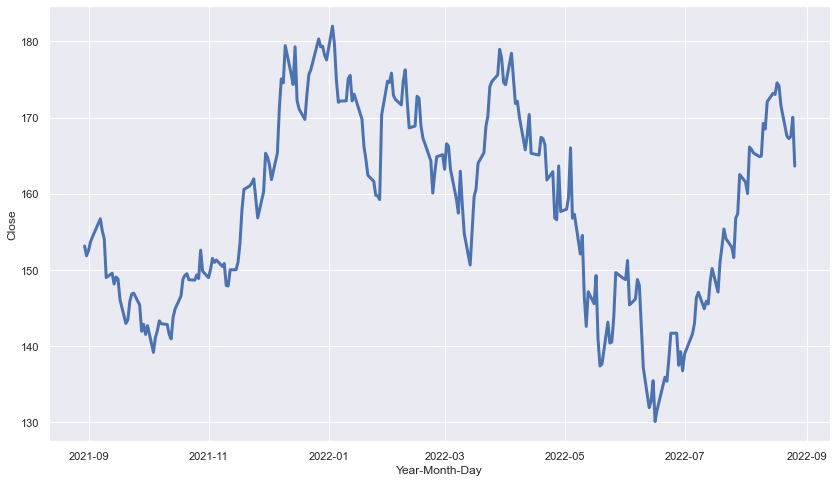

In [4]:
ax = sns.lineplot(data=df, x='Date', y='Close', palette='viridis', legend='full', lw=3)
plt.ylabel('Close')
plt.xlabel('Year-Month-Day')
plt.show()

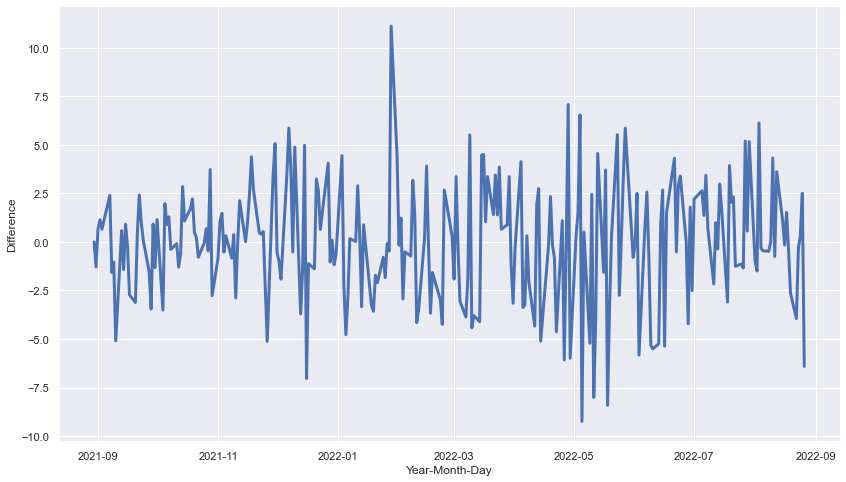

        Date        Open        High  DifferenceValues         Low  \
0 2021-08-30  149.000000  153.490005          0.000000  148.610001   
1 2021-08-31  152.660004  152.800003         -1.289993  151.289993   
2 2021-09-01  152.830002  154.979996          0.679993  152.339996   
3 2021-09-02  153.869995  154.720001          1.139999  152.399994   
4 2021-09-03  153.759995  154.630005          0.650009  153.089996   

        Close   Adj Close    Volume  Forecast  
0  153.119995  152.266754  90956700       NaN  
1  151.830002  150.983963  86453100       NaN  
2  152.509995  151.660156  80313700       NaN  
3  153.649994  152.793808  71115500       NaN  
4  154.300003  153.440201  57808700       NaN  


In [10]:
updatedDate = df.copy()
for index in updatedDate.index:
    if index > 0:
        # print("Before: " + str(updatedDate.loc[index, 'Close']))
        updatedDate.loc[index, 'Close'] = df.loc[index, 'Close'] - df.loc[index - 1, 'Close']
        # print("After: " + str(updatedDate.loc[index, 'Close']))
    else:
        updatedDate.loc[index, 'Close'] = 0
        
ax = sns.lineplot(data=updatedDate, x='Date', y='Close', palette='viridis', legend='full', lw=3)
plt.ylabel('Difference')
plt.xlabel('Year-Month-Day')
plt.show()

differenceValues = updatedDate['Close'].values.tolist()
df.insert(3, "DifferenceValues", differenceValues, False)
print(df.head())

In [11]:
df["Forecast"] = np.nan
df.describe()

,Open,High,DifferenceValues,Low,Close,Adj Close,Volume,Forecast
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02,0.0
mean,157.993028,160.007649,0.041833,156.179083,158.180797,157.684124,8.824087e+07,NaN
std,12.690973,12.690269,3.042100,12.562582,12.613367,12.582541,2.645012e+07,NaN
min,130.070007,132.389999,-9.250000,129.039993,130.059998,129.879593,4.100000e+07,NaN
25%,148.174995,149.434998,-1.575004,146.480004,148.294998,147.783249,6.946830e+07,NaN
50%,158.820007,161.020004,0.050003,155.979996,158.520004,158.067886,8.250750e+07,NaN
75%,169.385002,171.065002,2.115006,167.300003,169.060005,168.770233,1.003336e+08,NaN
max,182.630005,182.940002,11.110001,179.119995,182.009995,181.259918,1.954327e+08,NaN


In [12]:
from statsmodels.tsa.stattools import adfuller

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [13]:
adfuller_test(df['Close'])

ADF Test Statistic : -1.910395418208232
p-value : 0.327186691821458
#Lags Used : 0
Number of Observations Used : 250
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [14]:
adfuller_test(df['DifferenceValues'])

ADF Test Statistic : -15.56144242486101
p-value : 2.0400962984804414e-28
#Lags Used : 0
Number of Observations Used : 250
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [60]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Close'], trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1269.743, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1271.741, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1271.741, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1267.791, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1273.647, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.607 seconds


In [56]:
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)

(221, 9) (30, 9)


In [68]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(train['Close'],order=(0,1,0))
model=model.fit()
model.summary()

E:\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  220
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -558.942
Method:                           css   S.D. of innovations              3.070
Date:                Fri, 02 Sep 2022   AIC                           1121.884
Time:                        00:54:19   BIC                           1128.671
Sample:                             1   HQIC                          1124.625
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0134      0.207     -0.065      0.948      -0.419       0.392
==============================================================================
"""

221    150.156589
222    150.143180
223    150.129771
224    150.116362
225    150.102953
226    150.089544
227    150.076134
228    150.062725
229    150.049316
230    150.035907
231    150.022498
232    150.009089
233    149.995680
234    149.982271
235    149.968862
236    149.955453
237    149.942044
238    149.928635
239    149.915226
240    149.901816
241    149.888407
242    149.874998
243    149.861589
244    149.848180
245    149.834771
246    149.821362
247    149.807953
248    149.794544
249    149.781135
250    149.767726
Name: ARIMA Predictions, dtype: float64


<AxesSubplot:>

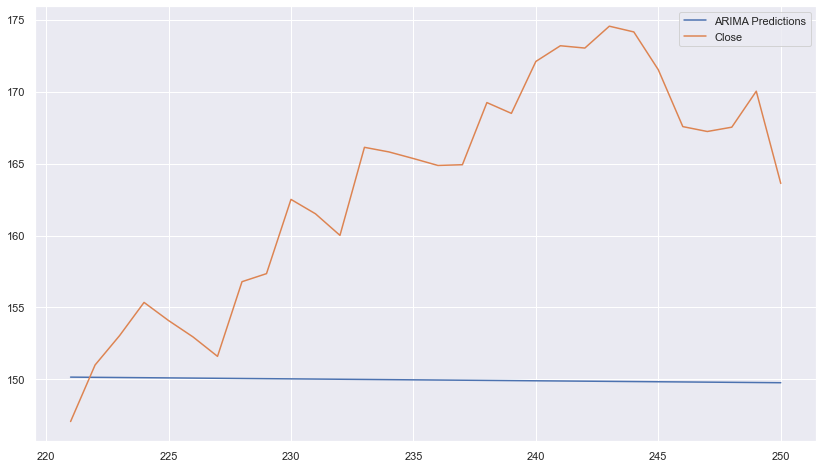

In [69]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
print(pred)
pred.plot(legend=True)
test['Close'].plot(legend=True)

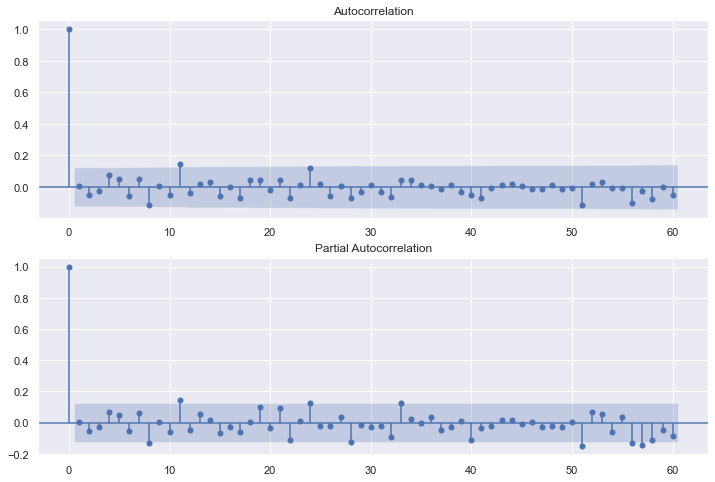

In [15]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['DifferenceValues'], lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['DifferenceValues'], lags=60, ax=ax2)

In [37]:
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df['DifferenceValues'], order=(10,1,1))
model_fit = model.fit()

E:\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [38]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D.DifferenceValues   No. Observations:                  250
Model:                ARIMA(10, 1, 1)   Log Likelihood                -631.028
Method:                       css-mle   S.D. of innovations              2.984
Date:                Thu, 01 Sep 2022   AIC                           1288.056
Time:                        21:05:14   BIC                           1333.835
Sample:                             1   HQIC                          1306.481
                                                                              
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0001      0.002      0.047      0.963      -0.005       0.005
ar.L1.D.DifferenceValues      0.0202      0.064      0.316      0.752      -0.105       0.145
ar.L2.D.DifferenceValues     -0.0617      0.064     -0.969      0.333      -0.186       0.063
ar.L3.D.DifferenceValues     -0.0190      0.063     -0.301      0.764      -0.143       0.105
ar.L4.D.DifferenceValues      0.0774      0.063      1.228      0.219      -0.046       0.201
ar.L5.D.DifferenceValues      0.0505      0.063      0.801      0.423      -0.073       0.174
ar.L6.D.DifferenceValues     -0.0516      0.063     -0.818      0.413      -0.175       0.072
ar.L7.D.DifferenceValues      0.0643      0.063      1.022      0.307      -0.059       0.188
ar.L8.D.DifferenceValues     -0.1297      0.063     -2.061      0.039      -0.253      -0.006
ar.L9.D.DifferenceValues      0.0088      0.064      0.138      0.890      -0.116       0.134
ar.L10.D.DifferenceValues    -0.0561      0.064     -0.882      0.378      -0.181       0.069
ma.L1.D.DifferenceValues     -0.9999      0.014    -69.328      0.000      -1.028      -0.972
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0930           -0.4454j            1.1803           -0.4384
AR.2            -1.0930           +0.4454j            1.1803            0.4384
AR.3             1.1884           -0.4040j            1.2552           -0.0521
AR.4             1.1884           +0.4040j            1.2552            0.0521
AR.5             0.6247           -1.1772j            1.3327           -0.1724
AR.6             0.6247           +1.1772j            1.3327            0.1724
AR.7            -0.6031           -1.2986j            1.4318           -0.3192
AR.8            -0.6031           +1.2986j            1.4318            0.3192
AR.9            -0.0384           -1.4929j            1.4934           -0.2541
AR.10           -0.0384           +1.4929j            1.4934            0.2541
MA.1             1.0001           +0.0000j            1.0001            0.0000
------------------------------------------------------------------------------
"""

200   -0.279677
201   -1.422388
202    0.195769
203    0.377501
204    0.747135
205   -0.264930
206    0.514578
207   -0.675186
208    0.010888
209   -0.119259
210   -0.000214
211    0.075284
212   -0.177525
213    0.070941
214   -0.149978
215    0.115762
216   -0.043476
217    0.041026
218    0.005777
219   -0.018240
220    0.037113
221   -0.027747
222    0.039874
223   -0.024420
224    0.017067
225   -0.009944
226   -0.000018
227    0.004472
228   -0.008651
229    0.008542
230   -0.009711
231    0.006598
232   -0.005056
233    0.002602
234   -0.000266
235   -0.000946
236    0.002227
237   -0.002222
238    0.002576
239   -0.001697
240    0.001537
241   -0.000570
242    0.000302
243    0.000367
244   -0.000402
245    0.000735
246   -0.000516
247    0.000615
248   -0.000270
249    0.000310
250    0.000046
dtype: float64


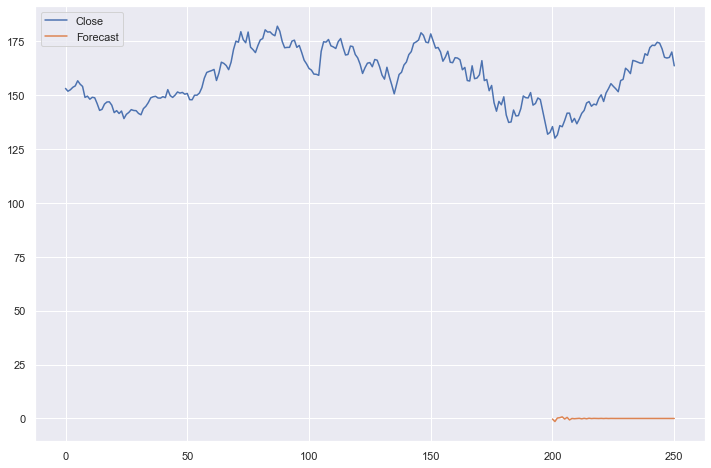

In [39]:
df['Forecast']=model_fit.predict(start=200,end=250,dynamic=True)
df[['Close','Forecast']].plot(figsize=(12,8))
print(model_fit.predict(start=200,end=250,dynamic=True))

<AxesSubplot:>

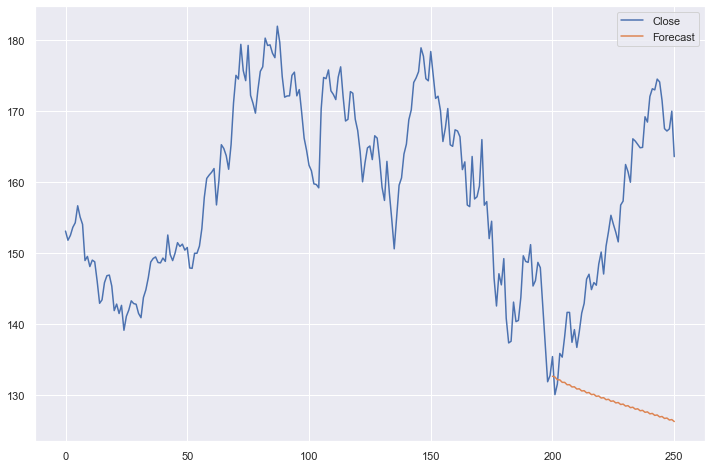

In [40]:
model=sm.tsa.statespace.SARIMAX(df['Close'],order=(1, 1, 1),seasonal_order=(1,1,1,2))
results=model.fit()

df['Forecast']=results.predict(start=200,end=250,dynamic=True)
df[['Close','Forecast']].plot(figsize=(12,8))